# Question 1

In [138]:
import numpy as np
from scipy.linalg import block_diag

# Parameters
kappa = 5e-5
lmbda = 3
L = 5e-5
beta = 0.0065
H = 0.05
dt = 1e-3
N = 20
x0 = np.array([1000.0, 0.0, beta])
C = np.array([[1,0,0]])

# Nonlinear functions
def F(x):
    Cn = float(x[0])
    Cp = float(x[1])
    rho_th = float(x[2])
    return np.array([(rho_th - beta) / L * Cn + lmbda * Cp,
                     (beta/L) * Cn - lmbda * Cp,
                     -kappa * H * Cn])
def G(x):
    Cn = x[0]
    return np.array([
        (1 / L) * Cn,
        0.0,
        0.0
    ])

def f(x):
    return x + F(x) * dt

def g(x):
    return G(x) * dt

# Jacobian of F
def J_F(x):
    Cn = float(x[0])
    Cp = float(x[1])
    rho_th = float(x[2])
    return np.array([
        [(rho_th - beta) / L,      lmbda,         Cn / L],
        [beta / L,                -lmbda,             0],
        [-kappa * H,                   0,             0]
    ])

def A_t(x):
    return np.eye(3) + J_F(x) * dt

def B_t(x):
    return g(x)  # shorthand

T = 100  # Total simulation time steps
x_sim = np.zeros((T + 1, 3))
x_sim[0] = x0

u_sim = np.zeros(T)

for t in range(T):
    # === Step 1: Free response ===
    z = np.zeros((N + 1, 3))
    z[0] = x_sim[t]
    A_list, B_list = [], []

    for k in range(N):
        A_list.append(A_t(z[k]))
        B_list.append(B_t(z[k]))
        z[k + 1] = f(z[k])

    # === Step 2: Build Gamma matrices ===
    Gamma_yz = block_diag(*([C] * N))
    Gamma_yu = np.zeros((N, N))

    for n in range(N):
        for j in range(n + 1):
            M = np.eye(3)
            for k in range(n - 1, j, -1):
                M = M @ A_list[k]
            Gamma_yu[n, j] = (C @ M @ B_list[j])[0]

    Z_N = z[1:N+1].reshape(-1, 1)
    W_N = 1e4 * np.ones((N, 1))

    # Step 3: Solve the optimal control problem with weights
    Q_y = np.eye(N)            # Output weight: 1
    Q_u = 1e-3 * np.eye(N)     # Input weight: 1e-3

    rhs = Gamma_yz @ Z_N - W_N
    b = Gamma_yu.T @ Q_y @ rhs
    H_qp = Gamma_yu.T @ Q_y @ Gamma_yu + Q_u
    U_N = -np.linalg.solve(H_qp, b)

    # === Step 4: Apply first input and step forward ===
    u_t = U_N[0, 0]
    u_sim[t] = u_t
    x_sim[t + 1] = f(x_sim[t]) + g(x_sim[t]) * u_t


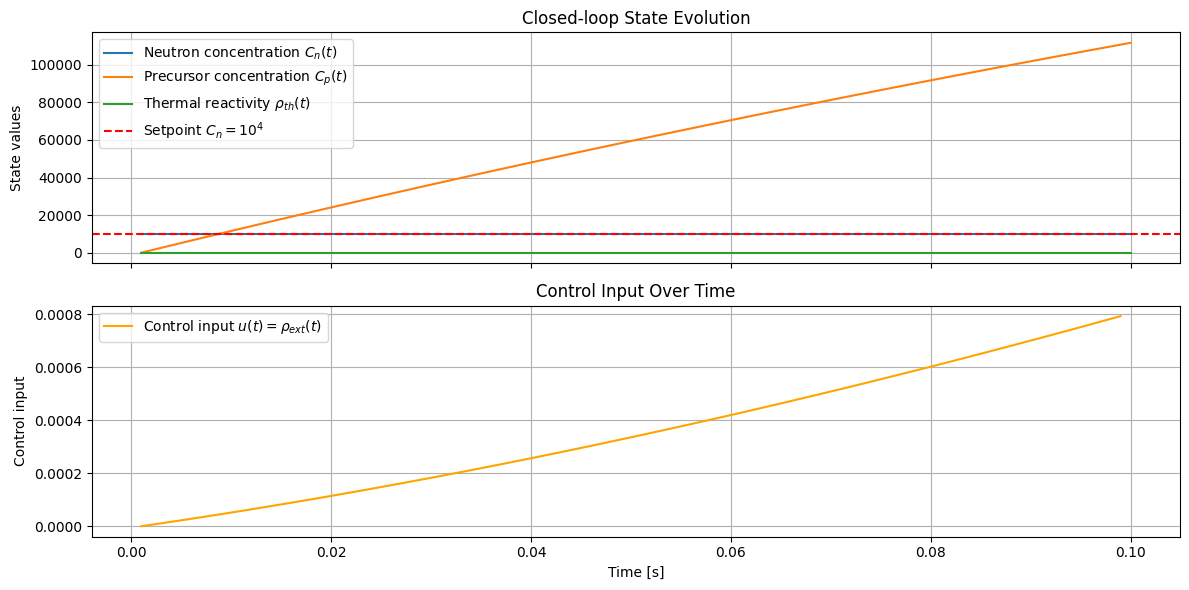

In [139]:
import matplotlib.pyplot as plt

time = np.arange(T + 1) * dt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top plot: all state variables
ax1.plot(time[1:], x_sim[1:, 0], label='Neutron concentration $C_n(t)$')
ax1.plot(time[1:], x_sim[1:, 1], label='Precursor concentration $C_p(t)$')
ax1.plot(time[1:], x_sim[1:, 2], label='Thermal reactivity $\\rho_{th}(t)$')
ax1.axhline(1e4, color='r', linestyle='--', label='Setpoint $C_n=10^4$')
ax1.set_ylabel('State values')
ax1.set_title('Closed-loop State Evolution')
ax1.grid(True)
ax1.legend()

# Bottom plot: control input
ax2.plot(time[1:-1], u_sim[1:], label='Control input $u(t) = \\rho_{ext}(t)$', color='orange')
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('Control input')
ax2.set_title('Control Input Over Time')
ax2.grid(True)
ax2.legend()

plt.tight_layout()
plt.show()


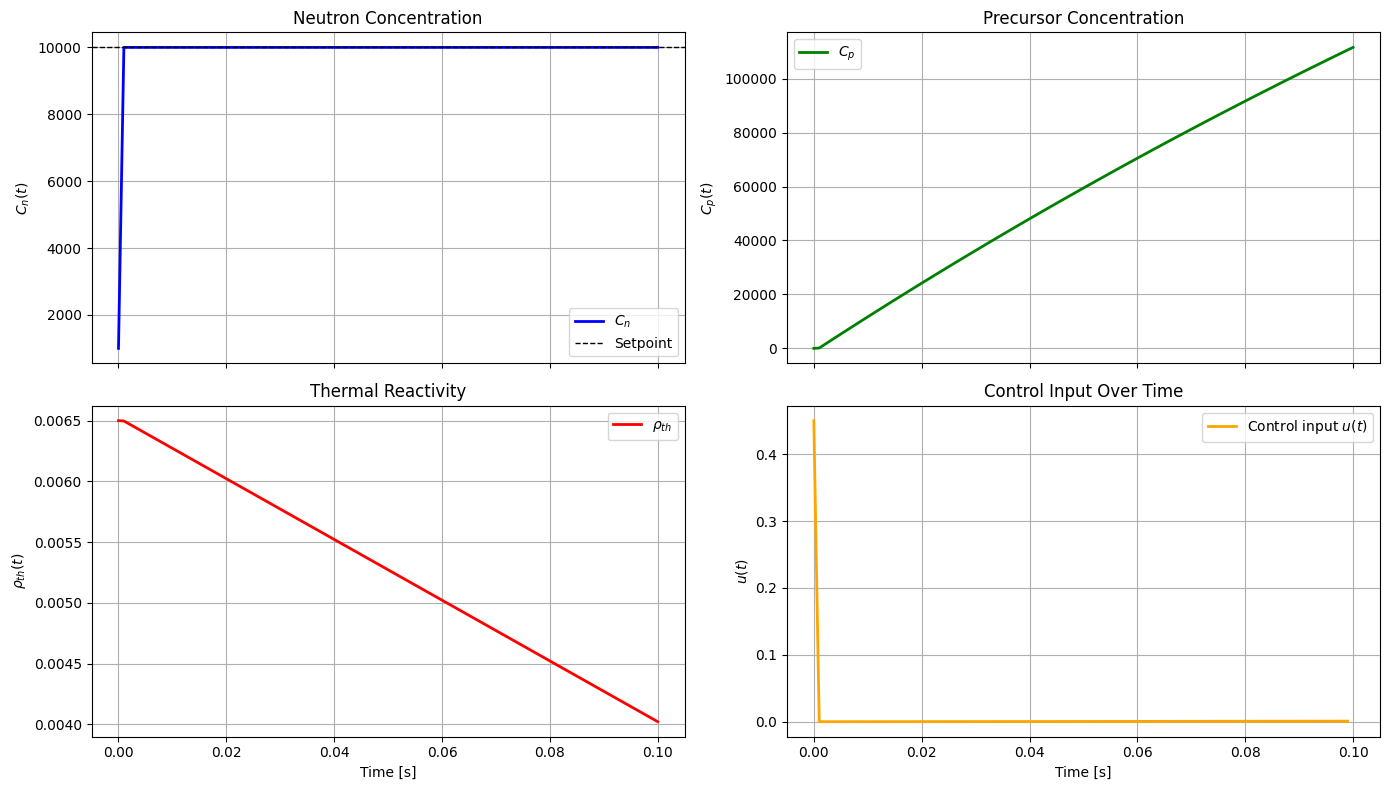

In [164]:
import matplotlib.pyplot as plt

# Sample placeholder arrays (replace with actual x_true, x_est, u, y)
time = np.arange(T + 1) * dt

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# === (0, 0): Cn state (true vs estimate) ===
axs[0, 0].plot(time, x_sim[:, 0], label='$C_n$', linewidth=2, color = 'b')
axs[0, 0].axhline(1e4, color='black', linestyle='--', label='Setpoint',linewidth=1)
axs[0, 0].set_ylabel('$C_n(t)$')
axs[0, 0].set_title('Neutron Concentration')
axs[0, 0].grid(True)
axs[0, 0].legend()

# === (0, 1): Cp state (true vs estimate) ===
axs[0, 1].plot(time, x_sim[:, 1], label='$C_p$', linewidth=2, color = 'g')
axs[0, 1].set_ylabel('$C_p(t)$')
axs[0, 1].set_title('Precursor Concentration')
axs[0, 1].grid(True)
axs[0, 1].legend()

# === (1, 0): rho_th state (true vs estimate) ===
axs[1, 0].plot(time, x_sim[:, 2], label='$\\rho_{th}$', linewidth=2, color = 'red')
axs[1, 0].set_xlabel('Time [s]')
axs[1, 0].set_ylabel('$\\rho_{th}(t)$')
axs[1, 0].set_title('Thermal Reactivity')
axs[1, 0].grid(True)
axs[1, 0].legend()

# === (1, 1): Control input ===
axs[1, 1].plot(time[:-1], u_sim, label='Control input $u(t)$', color='orange',linewidth=2)
axs[1, 1].set_xlabel('Time [s]')
axs[1, 1].set_ylabel('$u(t)$')
axs[1, 1].set_title('Control Input Over Time')
axs[1, 1].grid(True)
axs[1, 1].legend()

plt.tight_layout()
plt.show()


# Question 2

In [182]:
import numpy as np
from scipy.linalg import block_diag

# === PARAMETERS ===
kappa = 5e-5
lmbda = 3
L = 5e-5
beta = 0.0065
H = 0.05
dt = 1e-3
N = 20  # MPC horizon
T = 100  # total time steps
x0 = np.array([1000.0, 0.0, beta])

# === RANDOM SEED AND NOISE ===
np.random.seed(33)
R_v = np.diag([1.0, 1.0, 1e-8])
R_e = np.diag([0.1, 0.1])
v_noise = np.random.multivariate_normal(np.zeros(3), R_v, size=T)
e_noise = np.random.multivariate_normal(np.zeros(2), R_e, size=T)

# === OUTPUT MATRIX ===
C = np.array([[1, 0, 0],
              [0, 1, 0]])

# === SYSTEM FUNCTIONS ===
def F(x):
    Cn, Cp, rho_th = float(x[0]), float(x[1]), float(x[2])
    return np.array([(rho_th - beta) / L * Cn + lmbda * Cp,
                     (beta / L) * Cn - lmbda * Cp,
                     -kappa * H * Cn])

def G(x):
    return np.array([(1 / L) * x[0], 0.0, 0.0])

def f(x): return x + F(x) * dt
def g(x): return G(x) * dt

def J_F(x):
    Cn, Cp, rho_th = float(x[0]), float(x[1]), float(x[2])
    return np.array([[(rho_th - beta) / L, lmbda, Cn / L],
                     [beta / L, -lmbda, 0],
                     [-kappa * H, 0, 0]])

def A_t(x): return np.eye(3) + J_F(x) * dt
def B_t(x): return g(x)

# === STORAGE ===
x_true = np.zeros((T + 1, 3))
x_true[0] = x0
x_est = np.zeros((T + 1, 3))
x_est[0] = x0
P = np.eye(3)
u = np.zeros(T)
y = np.zeros((T + 1, 2))
# === pre define u ===
u = np.ones(T)*0.01 + np.random.random(size=T)*0.05
    

# === MEASUREMENT, SIMULATION, EKF ===
def measurent(t): y[t] = C @ x_true[t] + e_noise[t]

def sim(t): x_true[t + 1] = f(x_true[t]) + g(x_true[t]) * u[t] + v_noise[t]

def predict(t):
    global P
    x_est[t + 1] = f(x_est[t]) + g(x_est[t]) * u[t]
    A = A_t(x_est[t])
    P = A @ P @ A.T + R_v

def update(t):
    global P
    y_pred = C @ x_est[t]
    innovation = y[t] - y_pred
    S = C @ P @ C.T + R_e
    K = np.linalg.solve(S, C @ P).T
    x_est[t] += K @ innovation
    P = (np.eye(3) - K @ C) @ P


# === MAIN LOOP ===
for t in range(T):
    measurent(t)
    update(t)
    if t < T: 
        predict(t)
        sim(t)


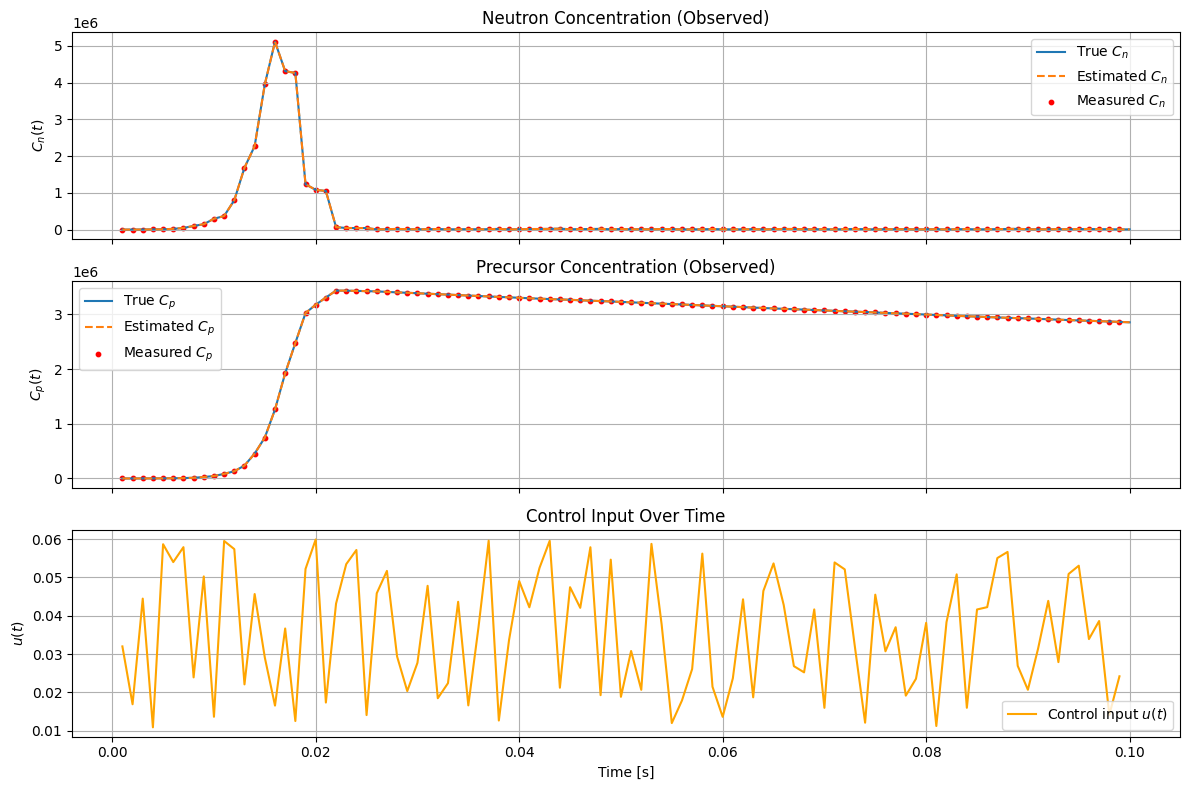

In [183]:
import matplotlib.pyplot as plt

time = np.arange(T + 1) * dt

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# === Plot C_n(t) ===
axs[0].plot(time[1:], x_true[1:, 0], label='True $C_n$', linewidth=1.5)
axs[0].plot(time[1:], x_est[1:, 0], '--', label='Estimated $C_n$')
axs[0].scatter(time[1:-1], y[1:-1, 0], s=10, alpha=1, label='Measured $C_n$',color = 'red')
axs[0].set_ylabel('$C_n(t)$')
axs[0].set_title('Neutron Concentration (Observed)')
axs[0].grid(True)
axs[0].legend()

# === Plot C_p(t) ===
axs[1].plot(time[1:], x_true[1:, 1], label='True $C_p$', linewidth=1.5)
axs[1].plot(time[1:], x_est[1:, 1], '--', label='Estimated $C_p$')
axs[1].scatter(time[1:-1], y[1:-1, 1], s=10, alpha=1, label='Measured $C_p$',color = 'red')
axs[1].set_ylabel('$C_p(t)$')
axs[1].set_title('Precursor Concentration (Observed)')
axs[1].grid(True)
axs[1].legend()

# === Plot control input u(t) ===
axs[2].plot(time[1:-1], u[1:], color='orange', label='Control input $u(t)$')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('$u(t)$')
axs[2].set_title('Control Input Over Time')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()


# Question 3

In [166]:
import numpy as np
from scipy.linalg import block_diag

# === PARAMETERS ===
kappa = 5e-5
lmbda = 3
L = 5e-5
beta = 0.0065
H = 0.05
dt = 1e-3
N = 20  # MPC horizon
T = 100  # total time steps
x0 = np.array([1000.0, 0.0, beta])

# === RANDOM SEED AND NOISE ===
np.random.seed(33)
R_v = np.diag([1.0, 1.0, 1e-8])
R_e = np.diag([0.1, 0.1])
v_noise = np.random.multivariate_normal(np.zeros(3), R_v, size=T)
e_noise = np.random.multivariate_normal(np.zeros(2), R_e, size=T)

# === OUTPUT MATRIX ===
C = np.array([[1, 0, 0],
              [0, 1, 0]])

# === SYSTEM FUNCTIONS ===
def F(x):
    Cn, Cp, rho_th = float(x[0]), float(x[1]), float(x[2])
    return np.array([(rho_th - beta) / L * Cn + lmbda * Cp,
                     (beta / L) * Cn - lmbda * Cp,
                     -kappa * H * Cn])

def G(x):
    return np.array([(1 / L) * x[0], 0.0, 0.0])

def f(x): return x + F(x) * dt
def g(x): return G(x) * dt

def J_F(x):
    Cn, Cp, rho_th = float(x[0]), float(x[1]), float(x[2])
    return np.array([[(rho_th - beta) / L, lmbda, Cn / L],
                     [beta / L, -lmbda, 0],
                     [-kappa * H, 0, 0]])

def A_t(x): return np.eye(3) + J_F(x) * dt
def B_t(x): return g(x)

# === STORAGE ===
x_true = np.zeros((T + 1, 3))
x_true[0] = x0
x_est = np.zeros((T + 1, 3))
x_est[0] = x0
P = np.eye(3)
u = np.zeros(T)
y = np.zeros((T + 1, 2))

# === MEASUREMENT, SIMULATION, EKF ===
def measurent(t): y[t] = C @ x_true[t] + e_noise[t]

def sim(t): x_true[t + 1] = f(x_true[t]) + g(x_true[t]) * u[t] + v_noise[t]

def predict(t):
    global P
    x_est[t + 1] = f(x_est[t]) + g(x_est[t]) * u[t]
    A = A_t(x_est[t])
    P = A @ P @ A.T + R_v

def update(t):
    global P
    y_pred = C @ x_est[t]
    innovation = y[t] - y_pred
    S = C @ P @ C.T + R_e
    K = np.linalg.solve(S, C @ P).T
    x_est[t] += K @ innovation
    P = (np.eye(3) - K @ C) @ P

# === CONTROL FUNCTION (MPC) ===
def compute_control(x_now):
    # Step 1: Free response
    z = np.zeros((N + 1, 3))
    z[0] = x_now
    A_list, B_list = [], []
    for k in range(N):
        A_list.append(A_t(z[k]))
        B_list.append(B_t(z[k]))
        z[k + 1] = f(z[k])
    
    # Step 2: Build Gamma matrices
    Gamma_yz = block_diag(*([C] * N))
    Gamma_yu = np.zeros((2 * N, N))
    for n in range(N):
        for j in range(n + 1):
            M = np.eye(3)
            for k in range(n - 1, j, -1):
                M = M @ A_list[k]
            Gamma_yu[2 * n:2 * n + 2, j] = C @ M @ B_list[j]
    
    Z_N = z[1:N + 1].reshape(-1, 1)
    W_N = np.zeros((2 * N, 1))
    W_N[::2] = 1e4  # setpoint on Cn only
    
    Q_y = np.eye(2 * N)
    Q_y[1::2, 1::2] = 0  # weight only on Cn
    Q_u = 1e-3 * np.eye(N)
    
    rhs = Gamma_yz @ Z_N - W_N
    b = Gamma_yu.T @ Q_y @ rhs
    H_qp = Gamma_yu.T @ Q_y @ Gamma_yu + Q_u
    U_N = -np.linalg.solve(H_qp, b)
    return U_N[0, 0]

# === MAIN LOOP ===
for t in range(T):
    measurent(t)
    update(t)
    if t < T:
        u[t] = compute_control(x_est[t])
        predict(t)
        sim(t)


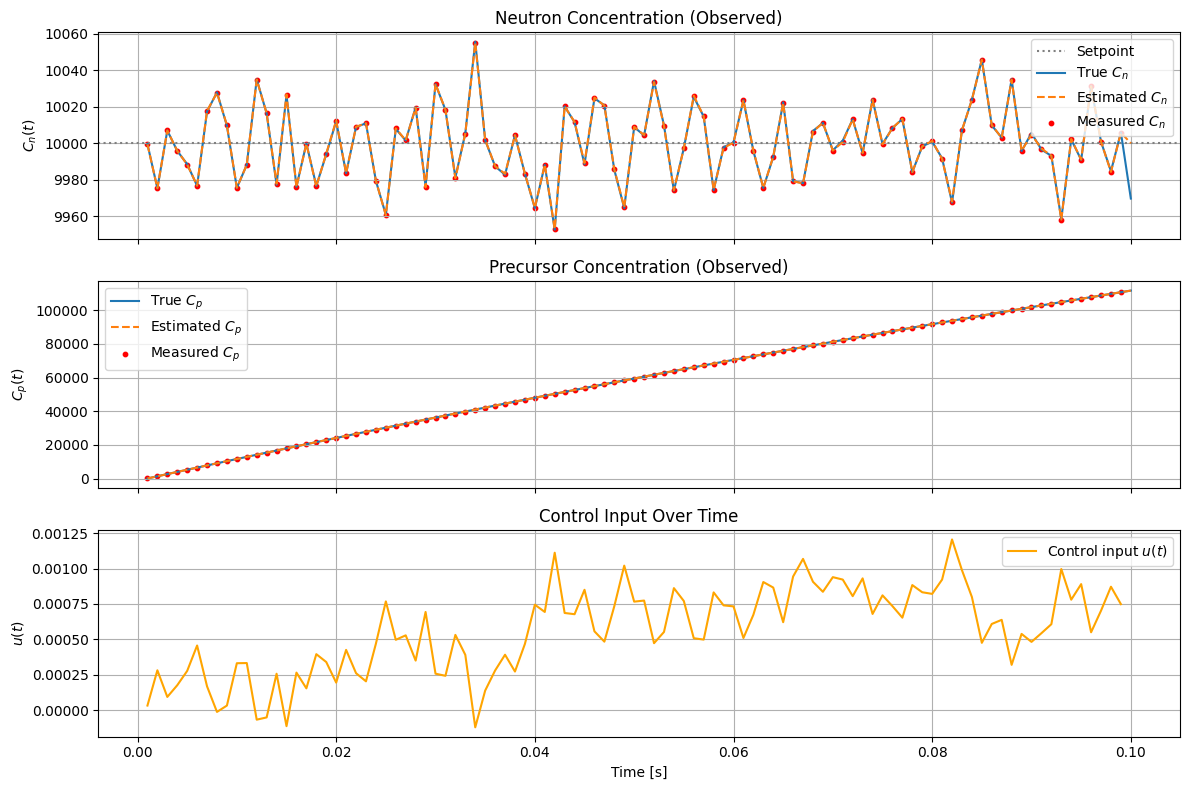

In [136]:
import matplotlib.pyplot as plt

time = np.arange(T + 1) * dt

fig, axs = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# === Plot C_n(t) ===
axs[0].axhline(1e4, color='grey', linestyle=':', label='Setpoint')
axs[0].plot(time[1:], x_true[1:, 0], label='True $C_n$', linewidth=1.5)
axs[0].plot(time[1:], x_est[1:, 0], '--', label='Estimated $C_n$')
axs[0].scatter(time[1:-1], y[1:-1, 0], s=10, alpha=1, label='Measured $C_n$',color = 'red')
axs[0].set_ylabel('$C_n(t)$')
axs[0].set_title('Neutron Concentration (Observed)')
axs[0].grid(True)
axs[0].legend()

# === Plot C_p(t) ===
axs[1].plot(time[1:], x_true[1:, 1], label='True $C_p$', linewidth=1.5)
axs[1].plot(time[1:], x_est[1:, 1], '--', label='Estimated $C_p$')
axs[1].scatter(time[1:-1], y[1:-1, 1], s=10, alpha=1, label='Measured $C_p$',color = 'red')
axs[1].set_ylabel('$C_p(t)$')
axs[1].set_title('Precursor Concentration (Observed)')
axs[1].grid(True)
axs[1].legend()

# === Plot control input u(t) ===
axs[2].plot(time[1:-1], u[1:], color='orange', label='Control input $u(t)$')
axs[2].set_xlabel('Time [s]')
axs[2].set_ylabel('$u(t)$')
axs[2].set_title('Control Input Over Time')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout()
plt.show()
